## Setup

In [1]:
%pip install swifter neuralprophet plotly kaleido statsmodels mariadb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt
import swifter
import dateutil
import datetime
import kaleido
import plotly
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import KPSSTest, auto_arima
from pmdarima.model_selection import train_test_split
import mariadb

from neuralprophet import NeuralProphet

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Data preparation

### Loading data

In [3]:
try:
    mydb = mariadb.connect(host="172.17.0.3", database = 'dados_tribunais',user="root", passwd="abc@123")
    query = "select * from processos where grau='JE' and tribunal='TJRN' and orgao_julgador = '4º JUIZADO ESPECIAL DA FAZENDA PÚBLICA';"
    df_tribunal = pd.read_sql(query,mydb)
    mydb.close() #close the connection
except Exception as e:
    mydb.close()
    print(str(e))

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1427397/3164487814.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tribunal = pd.read_sql(query,mydb)



In [4]:
#df_tribunal = pd.read_csv('dados/processados/serie_temporal_ajuizamento-TJRN_G1_2018.csv', header='infer', sep=';')
df_tribunal.drop(columns=['numero_processo', 'tribunal', 'classe', 'ultima_atualizacao', 'codigo', 'municipio', 'grau', 'assuntos', 'movimentos', 'data_ajuizamento'], inplace=True, errors='ignore')
print(df_tribunal.head(2))
#df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].swifter.apply(dateutil.parser.parse)
#df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].swifter.apply(datetime.datetime.date)

df_tribunal['data_sentenca'] = df_tribunal['data_sentenca'].swifter.apply(dateutil.parser.parse)
df_tribunal['data_sentenca'] = df_tribunal['data_sentenca'].swifter.apply(datetime.datetime.date)


                           orgao_julgador data_sentenca tempo_ate_sentenca  \
0  4º JUIZADO ESPECIAL DA FAZENDA PÚBLICA    2019-01-02               None   
1  4º JUIZADO ESPECIAL DA FAZENDA PÚBLICA    2019-03-18               None   

  tempo_entre_1e2_mov tempo_entre_2e3_mov tempo_entre_3e4_mov  mais60d  
0                   0                   0                   0        0  
1                   0                   7                   0        0  


Pandas Apply:   0%|          | 0/17129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17129 [00:00<?, ?it/s]

In [5]:
dataframe = df_tribunal.groupby(['data_sentenca']).size()
df_tribunal = dataframe.to_frame(name='quantidade')
df_tribunal = df_tribunal.rename_axis('data_sentenca').reset_index()
print(df_tribunal)

     data_sentenca  quantidade
0       2018-01-08           1
1       2018-01-09           2
2       2018-01-12           2
3       2018-01-16           1
4       2018-01-18           6
...            ...         ...
1409    2024-05-01           1
1410    2024-05-02           3
1411    2024-05-03          12
1412    2024-05-07           1
1413    2024-06-01         136

[1414 rows x 2 columns]


In [6]:
#df_tribunal['data_ajuizamento'] = pd.to_datetime(df_tribunal['data_ajuizamento'])

### Visualização dos dados

Série Temporal dos ajuizamentos ao longo do tempo

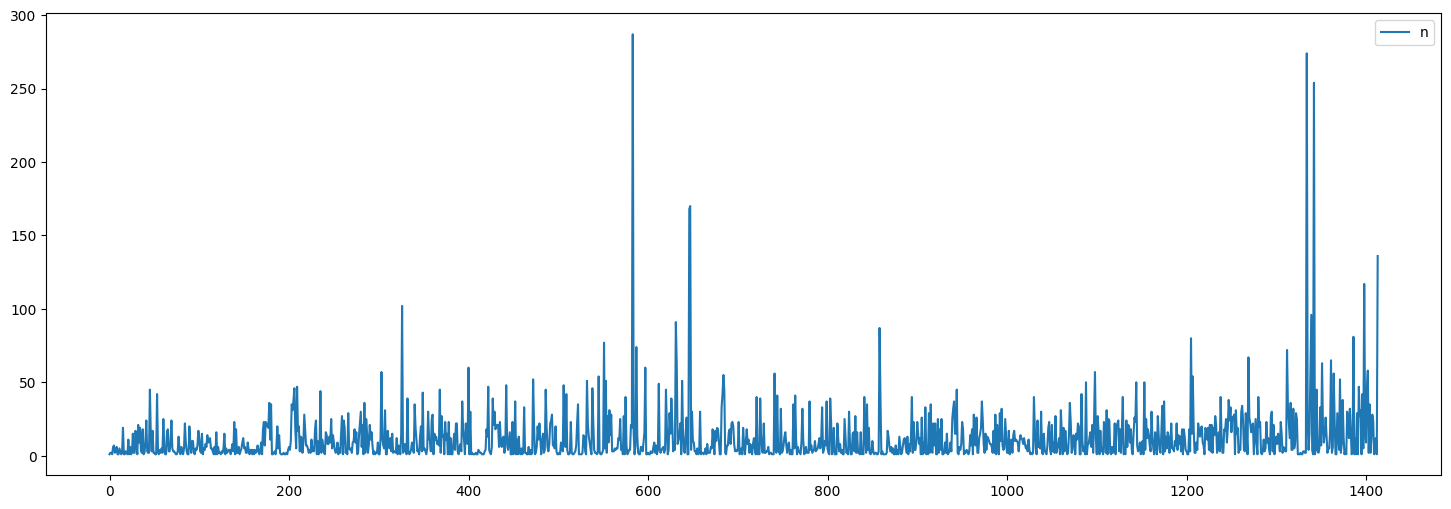

In [7]:
plt.figure(figsize=(18, 6))
plt.plot(df_tribunal['quantidade'])
plt.legend('número de sentenças')
plt.savefig('producao_4jefp.png', )

## Análise estatística

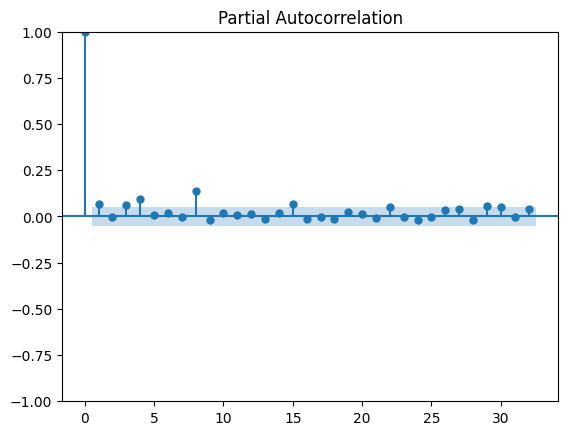

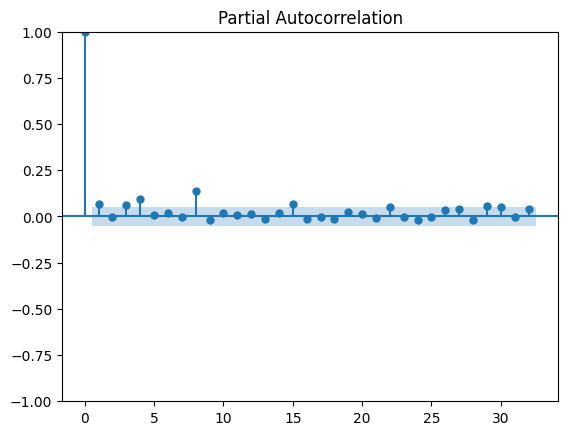

In [8]:
## PACF

df_pacf = df_tribunal
df_pacf.set_index('data_sentenca', inplace=True)
plot_pacf(df_pacf)

In [9]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_pacf.quantidade.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

if pval < 0.5:
    print('\n\nA série temporal é estacionária')
else:
    print('\n\nA série temporal não é estacionária')

ADF test statistic: -10.184891696247144
ADF p-values: 6.5478341689538556e-18
ADF number of lags used: 7
ADF number of observations: 1406
ADF critical values: {'1%': -3.4350095156582197, '5%': -2.863597846112653, '10%': -2.5678655888095925}
ADF best information criterion: 12159.609649512915


A série temporal é estacionária


# Métodos e modelos

## ARIMA e variantes

In [10]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}


In [11]:
def arima_fit_predict(ts, m, horizon, test_size):
  ts_train = ts[0:-(test_size+(horizon-1))].values
  ts_test = ts[-(test_size+(horizon-1)):].values

  model = auto_arima(ts_train, #X=None,
            start_p=2, start_q=2, max_p=6, max_d=2,
            max_q=6, start_P=1, start_Q=1, max_P=2,
            max_D=1, max_Q=2, max_order=15, m=m,
            stepwise=True, trace=True)

  direct_predict = model.predict(ts_test.shape[0])

  prevs_h_steps = []

  for t in tqdm(ts_test):
    prevs_h_steps.append(model.predict(horizon)[horizon-1])
    model.update(t)

  return prevs_h_steps[0:test_size], direct_predict[-test_size:]

In [12]:
test_size = 180
m = 30
horizon = 2
ts = df_pacf['quantidade']
prevs_h_steps, direct_predict = arima_fit_predict(ts, m, horizon, test_size)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=21.76 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=11048.033, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=10776.239, Time=2.41 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=10338.394, Time=7.84 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=11046.035, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=10339.128, Time=0.13 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=10337.967, Time=8.84 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=10338.119, Time=3.92 sec
 ARIMA(0,1,1)(2,0,1)[30] intercept   : AIC=10338.894, Time=29.72 sec
 ARIMA(0,1,1)(1,0,2)[30] intercept   : AIC=10338.791, Time=31.21 sec
 ARIMA(0,1,1)(0,0,2)[30] intercept   : AIC=10337.279, Time=22.78 sec
 ARIMA(0,1,0)(0,0,2)[30] intercept   : AIC=11049.050, Time=6.89 sec
 ARIMA(1,1,1)(0,0,2)[30] intercept   : AIC=inf, Time=13.96 sec
 ARIMA(0,1,2)(0,0,2)[30] intercept   : AIC=inf, Time=88.69 sec
 ARIMA(1,1,0)(0,0

100%|██████████| 181/181 [10:46<00:00,  3.57s/it]


(array([19570., 19601., 19631., 19662., 19692., 19723., 19754., 19783.,
        19814., 19844., 19875.]),
 [Text(19570.0, 0, '2023-08'),
  Text(19601.0, 0, '2023-09'),
  Text(19631.0, 0, '2023-10'),
  Text(19662.0, 0, '2023-11'),
  Text(19692.0, 0, '2023-12'),
  Text(19723.0, 0, '2024-01'),
  Text(19754.0, 0, '2024-02'),
  Text(19783.0, 0, '2024-03'),
  Text(19814.0, 0, '2024-04'),
  Text(19844.0, 0, '2024-05'),
  Text(19875.0, 0, '2024-06')])

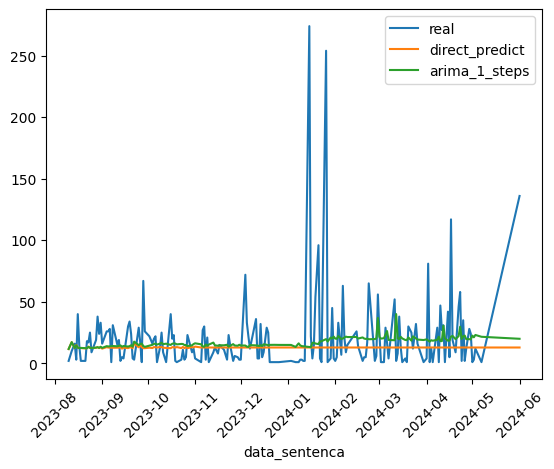

In [13]:
df_result = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result.plot()
plt.xticks(rotation=45)

In [14]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['direct_predict', 'arima_1_steps']:
  y_true = df_result['real']
  y_pred = df_result[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)
  
pd.DataFrame(metric_results)  

MSE       RMSE       MAPE        MAE        theil        ARV  \
0  1153.400362  33.961749  281.91060  16.655741  1856.907142  19.848977   
1  1105.250830  33.245313  385.51882  17.298856    91.444123  40.184232   

       POCID      model_name  
0  16.111111  direct_predict  
1  46.666667   arima_1_steps

## NeuralProphet

In [15]:
dados = pd.DataFrame()
df_tribunal.reset_index(inplace=True)
dados['ds'] = df_tribunal['data_sentenca']
dados['y'] = df_tribunal['quantidade']

In [16]:
#dados.to_csv('dados/neural_prophet_TJRN_G1_2018.csv', header=True, sep=';', index=False)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 80.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.data.processing._handle_missing_data) - Added 256 missing dates.


INFO - (NP.data.processing._handle_missing_data) - Dropped 18 rows at the end with NaNs in 'y' column.
WARNING - (NP.data.processing._handle_missing_data) - 335 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 335 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.919% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 494 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 494 missing values in column y were detected in total. 
INFO - (NP.data.processing._hand

Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 80.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 80.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 923 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 923 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 923 NaN values in column y were auto-imputed.


Predicting: 54it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


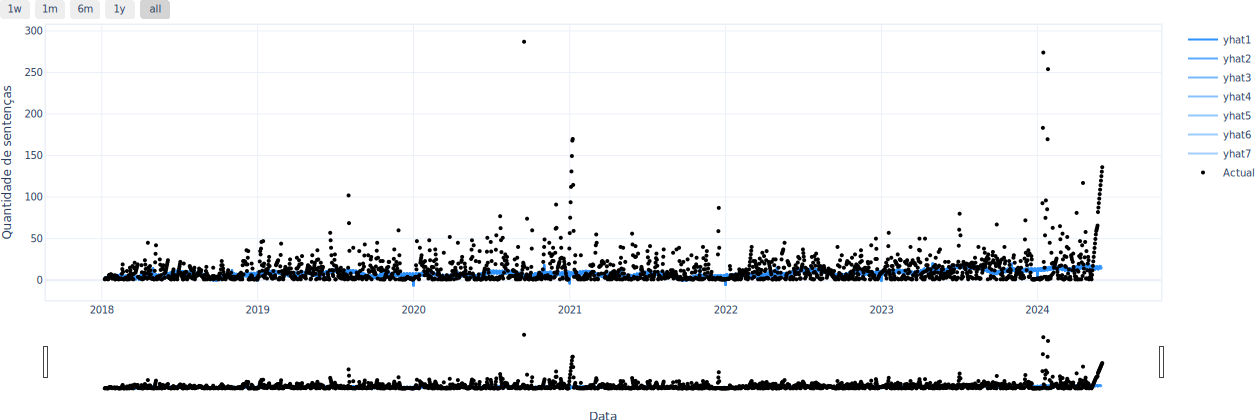

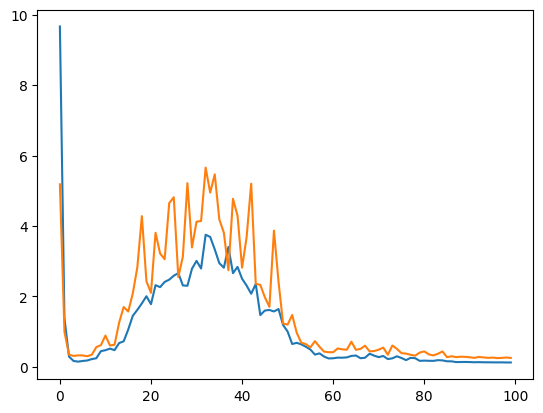

In [25]:
#dados = pd.read_csv('dados/neural_prophet_TJRN_G1_2018.csv', header='infer', sep=';')
#dados = dados[dados.y < 6000]
m = NeuralProphet(n_lags=1, n_forecasts=7, ar_layers=(16, 64))
m = m.add_country_holidays("BR")
m.set_plotting_backend("plotly-static")
df_train, df_val = m.split_df(dados, valid_p=0.25)
metrics = m.fit(df_train, validation_df=df_val, freq='D', progress="plot")
forecast = m.predict(dados)
m.plot(forecast, xlabel="Data", ylabel="Quantidade de sentenças", figsize=(18, 6))

In [18]:
m.plot_components(forecast)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/plot_model_parameters_plotly.py:377: RuntimeWarning:

invalid value encountered in divide




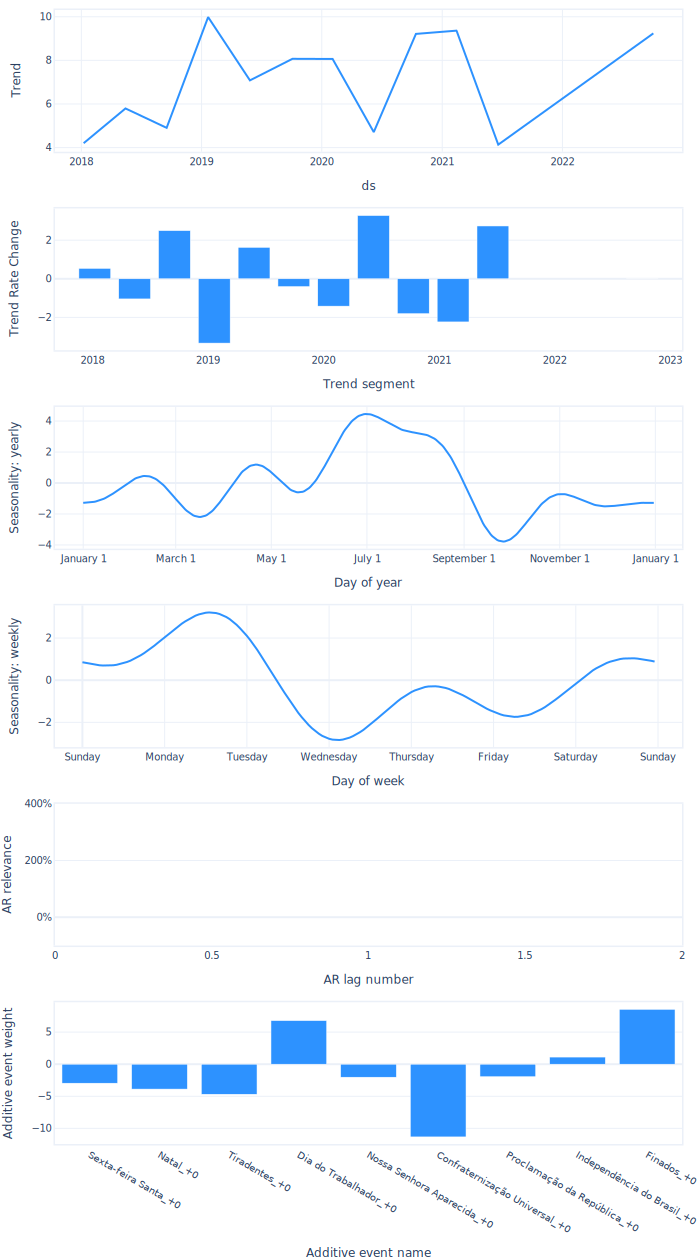

AttributeError: 'NoneType' object has no attribute 'savefig'

In [26]:
m.plot_parameters()

In [20]:
print(metrics.tail(5))

      MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch       MAE       RMSE  \
95  11.795842  23.245033  0.237061          0.0     95  7.809657  13.868397   
96  11.816154  23.193214  0.237536          0.0     96  7.816825  13.731409   
97  11.810689  23.222885  0.237442          0.0     97  7.799533  13.733594   
98  11.813986  23.208071  0.237530          0.0     98  7.816803  13.875855   
99  11.809810  23.220766  0.237447          0.0     99  7.815657  13.900661   

        Loss  RegLoss  
95  0.103891      0.0  
96  0.103939      0.0  
97  0.103771      0.0  
98  0.103842      0.0  
99  0.103862      0.0  


In [21]:
print(dados['y'].describe())

count    1414.000000
mean       12.113861
std        19.362864
min         1.000000
25%         2.000000
50%         6.000000
75%        16.000000
max       287.000000
Name: y, dtype: float64


## Prophet

In [22]:
recesso_judiciario = pd.DataFrame({
  'holiday': 'recesso_judiciario',
  'ds': pd.to_datetime(['2018-12-19', '2019-12-19', 
                        '2020-12-19', '2021-12-19',
                        '2022-12-19', '2023-12-19',
                        '2024-12-19', '2025-12-19']),
  'lower_window': 0,
  'upper_window': 18,
})

In [23]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

m = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.01,interval_width=0.99, holidays=recesso_judiciario)
m.add_country_holidays(country_name='BR')
m.fit(dados)
df_cv = cross_validation(m, initial='1080 days', period='60 days', horizon = '180 days', parallel="processes")

df_p = performance_metrics(df_cv)
df_p.head(5)

22:45:50 - cmdstanpy - INFO - Chain [1] start processing
22:45:50 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain

horizon         mse       rmse       mae      mape     mdape     smape  \
0 19 days  167.536450  12.943587  9.168032  2.544219  0.715294  0.916555   
1 20 days  135.271689  11.630636  8.656471  2.557320  0.715294  0.905393   
2 21 days  137.025613  11.705794  8.709317  2.429541  0.743017  0.906335   
3 22 days  140.723860  11.862709  8.813205  2.430006  0.709706  0.891784   
4 23 days  144.402461  12.016758  8.953216  2.494547  0.715294  0.894256   

   coverage  
0  0.990050  
1  0.995025  
2  0.995025  
3  0.995025  
4  0.995025

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_1427397/1305710298.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




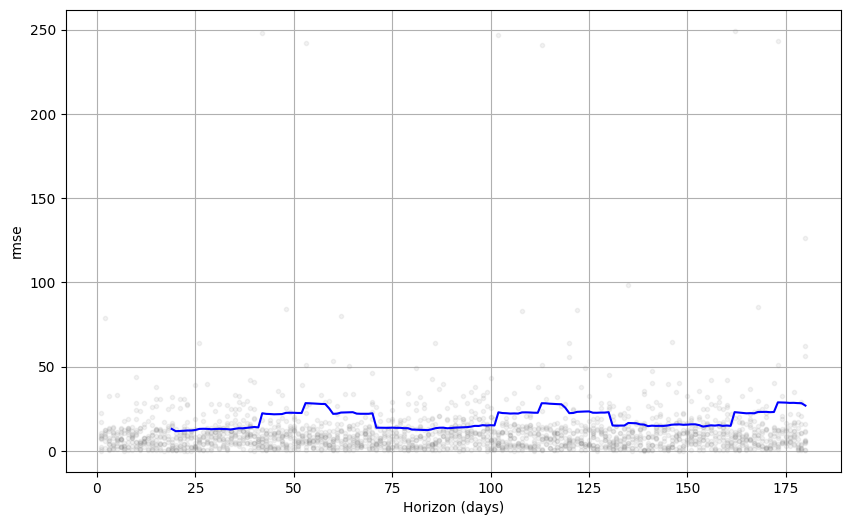

In [24]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')
fig.show()